In [1]:
from __future__ import print_function

import argparse
import math
import pickle
import random
import datetime
import numpy as np

import gym

import gym_2048

from policy_gradient import PolicyGradient
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/Users/yogesh/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gym.make("2048-v0")
env.reset()

# Policy gradient has high variance, seed for reproducability
env.seed(1)

'''
print("env.action_space", env.action_space)
print("env.observation_space", env.observation_space)
print("env.observation_space.high", env.observation_space.high)
print("env.observation_space.low", env.observation_space.low)
'''
RENDER_ENV = False
EPISODES = 50
EPISODE_WINDOW = EPISODES / 10
EPISODE_WINDOW_SHIFT = 10

#Progress tracking metrics
rewards = []
max_tile_values = []

QUIET = True

# Load checkpoint
load_path = "outputs/weights/2048-v0.ckpt"
save_path = "outputs/weights/2048-v0-temp.ckpt"

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Environment '<class 'gym_2048.envs.game2048_env.Game2048Env'>' has deprecated methods. Compatibility code invoked.


Using TensorFlow backend.


INFO:tensorflow:Restoring parameters from outputs/weights/2048-v0.ckpt


INFO:tensorflow:Restoring parameters from outputs/weights/2048-v0.ckpt


Didnt find saved model at outputs/weights/2048-v0.ckpt
Episode:  0
Episode:  1
Episode:  2
Episode:  3
Episode:  4
Episode:  5


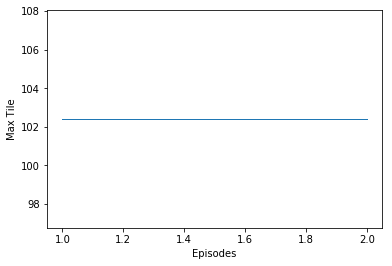

Episode:  6
Episode:  7
Episode:  8
Episode:  9
Episode:  10


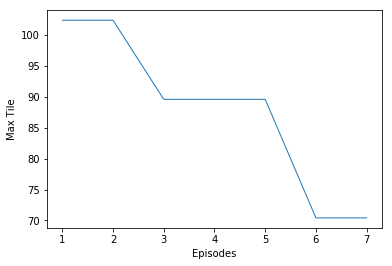

Episode:  11
Episode:  12
Episode:  13
Episode:  14
Episode:  15


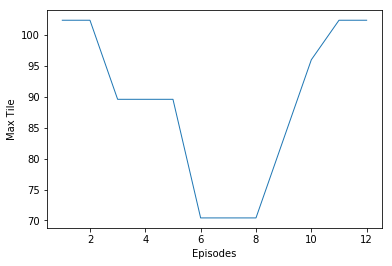

Episode:  16
Episode:  17
Episode:  18
Episode:  19
Episode:  20


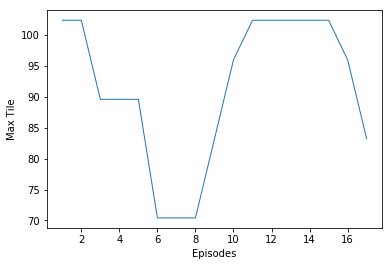

Episode:  21
Episode:  22
Episode:  23
Episode:  24
Episode:  25


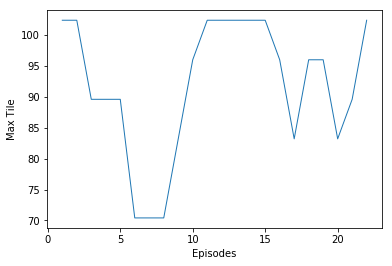

Episode:  26
Episode:  27
Episode:  28
Episode:  29
Episode:  30


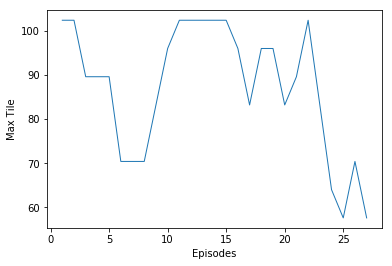

Episode:  31
Episode:  32
Episode:  33
Episode:  34
Episode:  35


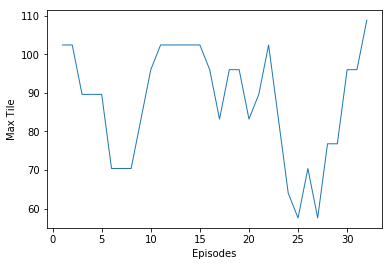

Episode:  36
Episode:  37
Episode:  38
Episode:  39
Episode:  40


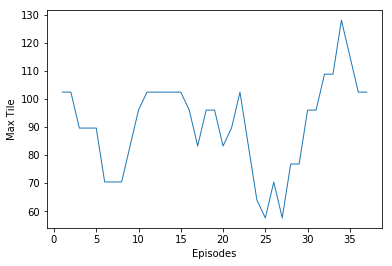

Episode:  41
Episode:  42
Episode:  43
Episode:  44
Episode:  45


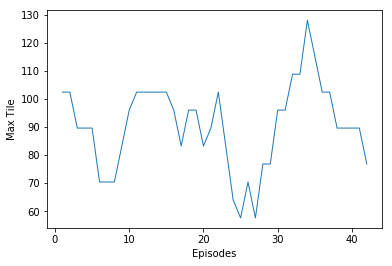

Episode:  46
Episode:  47
Episode:  48
Episode:  49


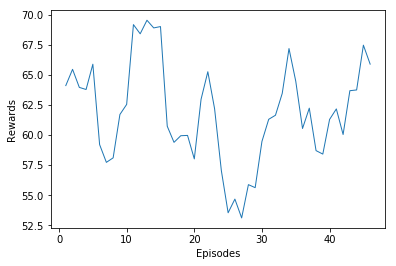

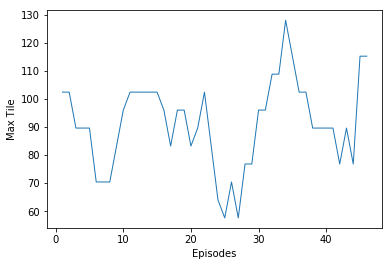

In [3]:
if __name__ == "__main__":

    PG = PolicyGradient(
        n_x = env.observation_space.shape[0],
        n_y = env.action_space.n,
        learning_rate=0.01,
        reward_decay=0.99,
        epochs=3,
        load_path=load_path,
        save_path=save_path
    )
    
    PG.quiet = QUIET

    for episode in range(EPISODES):

        observation = env.reset()
        episode_reward = 0
        max_tile_value_so_far = 0

        while True:
            if RENDER_ENV: env.render()

            # Choose an action based on observation
            action = PG.choose_action(observation)
            
            move_reward = 0

            while move_reward == 0:
                
                # Take action in the environment
                observation_, reward, done, info = env.step(action)
        
                if done: break
                
                # copying for while condition
                move_reward = reward
                
                if move_reward == 0:
                    # Get out of the invalid move loop by choosing remaining moves randomly
                    action = (action + 1 + np.random.randint(env.action_space.n - 1)) % env.action_space.n
            
                reward /= np.max(observation.flatten()) * 0.5
                
                # Store transition for training
                PG.store_transition(observation, action, reward)

            if done:
                episode_rewards_sum = sum(PG.episode_rewards)
                max_tile_value = np.max(observation.flatten())
                
                rewards.append(episode_rewards_sum)
                max_tile_values.append(max_tile_value)
                
                max_reward_so_far = np.amax(rewards)
                max_tile_value_so_far = np.amax(max_tile_values)

                print("Episode: ", episode)
                if not QUIET:
                    print("==========================================")
                    print("Max tile value: ", max_tile_value)
                    print("Reward: ", episode_rewards_sum)
                    print("Max tile value so far: ", max_tile_value_so_far)
                    print("Max reward so far: ", max_reward_so_far)

                # Train neural network
                discounted_episode_rewards_norm = PG.learn()
                
                break

            # Save new observation
            observation = observation_
        
        if episode > 0 and episode % EPISODE_WINDOW == 0:
            #PG.plot(y_data=rewards, y_label="Rewards", window=EPISODE_WINDOW)
            PG.plot(y_data=max_tile_values, y_label="Max Tile", window=EPISODE_WINDOW)
        
    PG.plot(y_data=rewards, y_label="Rewards", window=EPISODE_WINDOW)
    PG.plot(y_data=max_tile_values, y_label="Max Tile", window=EPISODE_WINDOW)
    